🍎 FRUIT QUALITY PREDICTOR - DEEP LEARNING SYSTEM

📊 Step 1: Analyzing and preparing dataset...
Class Distribution Analysis:
----------------------------------------
1: 114 samples (21.4%)
2: 104 samples (19.5%)
3: 100 samples (18.8%)
4: 114 samples (21.4%)
5: 100 samples (18.8%)

Imbalance Ratio: 1.14

Dataset split completed!

🚀 Step 2: Training ResNet-18 with advanced techniques...
Using device: cuda
Training samples: 425
Validation samples: 107
Classes: ['1', '2', '3', '4', '5']

Starting training with balanced regularization...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30: Train Loss: 0.5255, Train Acc: 78.82%, Val Loss: 7.6072, Val Acc: 40.19%, Time: 5.92s
Epoch 2/30: Train Loss: 0.3262, Train Acc: 88.47%, Val Loss: 0.8326, Val Acc: 76.64%, Time: 5.87s
Epoch 3/30: Train Loss: 0.2649, Train Acc: 91.53%, Val Loss: 2.3329, Val Acc: 52.34%, Time: 5.74s
Epoch 4/30: Train Loss: 0.2771, Train Acc: 91.06%, Val Loss: 1.7770, Val Acc: 54.21%, Time: 5.80s
Epoch 5/30: Train Loss: 0.1701, Train Acc: 94.82%, Val Loss: 0.4579, Val Acc: 83.18%, Time: 5.83s
Epoch 6/30: Train Loss: 0.7280, Train Acc: 84.20%, Val Loss: 0.4443, Val Acc: 85.98%, Time: 5.94s
Epoch 7/30: Train Loss: 0.5003, Train Acc: 85.47%, Val Loss: 0.2201, Val Acc: 94.39%, Time: 5.84s
Epoch 8/30: Train Loss: 0.3709, Train Acc: 90.04%, Val Loss: 0.2618, Val Acc: 91.59%, Time: 5.76s
Epoch 9/30: Train Loss: 0.4662, Train Acc: 88.52%, Val Loss: 0.2019, Val Acc: 93.46%, Time: 6.00s
Epoch 10/30: Train Loss: 0.2441, Train Acc: 94.07%, Val Loss: 0.1494, Val Acc: 97.20%, Time: 5.82s
Epoch 11/30: Train 

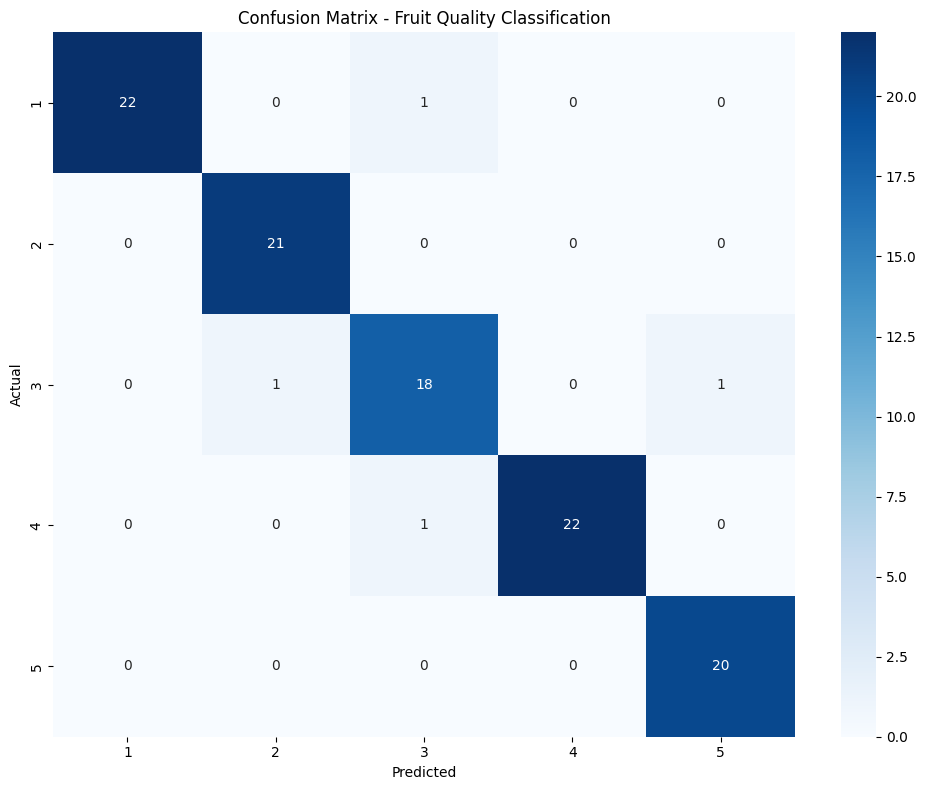

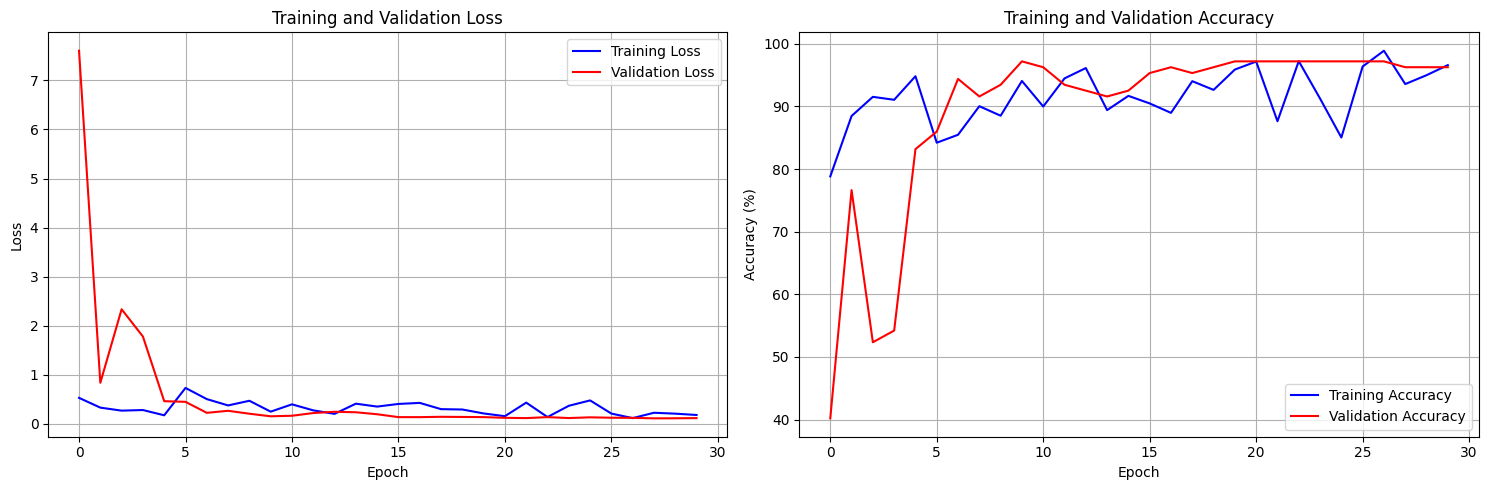


⚡ Step 3: Converting to ONNX for edge deployment...
Model successfully converted to ONNX: fruit_quality_model.onnx
ONNX model verification passed!

🔍 Step 4: Testing edge inference engine...

Sample prediction:
Image: /kaggle/working/apple_dataset_split/test/2/V006_80_0_00_02_01_25_0_c35_20201026_0087_S01_1_jpg.rf.7aaa8e410f61e46e2774b53ef9f16157.jpg
Predicted class: 2
Confidence: 0.9922
Inference time: 0.0286s

Benchmarking inference speed with 100 runs...
Average inference time: 0.0328s ± 0.0062s
Throughput: 30.50 images/second

✅ System Performance Summary:
   • Model: ResNet-18 with transfer learning
   • Advanced augmentation: MixUp, CLAHE, Color Jitter
   • Class imbalance handling: Weighted sampling
   • Edge optimization: ONNX conversion
   • Average inference time: 0.0328s
   • Meets <0.5s requirement: ✅

🎉 Fruit Quality Predictor system deployment ready!


In [5]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import onnx
import onnxruntime as ort


class DatasetAnalyzer:
    """Analyze dataset for class distribution and imbalance"""
    
    @staticmethod
    def analyze_class_distribution(dataset_dir):
        class_counts = {}
        total_samples = 0
        
        for class_name in os.listdir(dataset_dir):
            class_dir = os.path.join(dataset_dir, class_name)
            if os.path.isdir(class_dir):
                count = len(os.listdir(class_dir))
                class_counts[class_name] = count
                total_samples += count
        
        print("Class Distribution Analysis:")
        print("-" * 40)
        for class_name, count in sorted(class_counts.items()):
            percentage = (count / total_samples) * 100
            print(f"{class_name}: {count} samples ({percentage:.1f}%)")
        
        # Calculate imbalance ratio
        max_count = max(class_counts.values())
        min_count = min(class_counts.values())
        imbalance_ratio = max_count / min_count
        print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")
        
        return class_counts, imbalance_ratio

def prepare_dataset_split(original_dataset_dir, base_dir, test_size=0.2):
    """Prepare stratified train-test split"""
    
    # Create directories
    train_dir = os.path.join(base_dir, 'train')
    test_dir = os.path.join(base_dir, 'test')
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Analyze dataset first
    analyzer = DatasetAnalyzer()
    class_counts, imbalance_ratio = analyzer.analyze_class_distribution(original_dataset_dir)
    
    for class_name in os.listdir(original_dataset_dir):
        class_path = os.path.join(original_dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue
            
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        images = os.listdir(class_path)
        train_images, test_images = train_test_split(
            images, test_size=test_size, random_state=42, stratify=None
        )
        
        # Copy files
        for img in train_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(train_dir, class_name, img)
            shutil.copyfile(src, dst)
        
        for img in test_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(test_dir, class_name, img)
            shutil.copyfile(src, dst)
    
    print(f"\nDataset split completed!")
    return train_dir, test_dir, imbalance_ratio



class CLAHETransform:
    """Custom CLAHE (Contrast Limited Adaptive Histogram Equalization) transform"""
    
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    def __call__(self, image):
        # Convert PIL to numpy
        img_array = np.array(image)
        
        # Apply CLAHE to each channel
        if len(img_array.shape) == 3:
            img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
            img_array[:, :, 0] = self.clahe.apply(img_array[:, :, 0])
            img_array = cv2.cvtColor(img_array, cv2.COLOR_LAB2RGB)
        else:
            img_array = self.clahe.apply(img_array)
        
        return Image.fromarray(img_array)

class MixUp:
    """MixUp augmentation implementation"""
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def __call__(self, batch_x, batch_y):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1
        
        batch_size = batch_x.size(0)
        index = torch.randperm(batch_size)
        
        mixed_x = lam * batch_x + (1 - lam) * batch_x[index, :]
        y_a, y_b = batch_y, batch_y[index]
        
        return mixed_x, y_a, y_b, lam

def get_advanced_transforms(input_size=224, reduce_augmentation=False):
    """Get advanced augmentation transforms with option to reduce intensity"""
    
    if reduce_augmentation:
        # Lighter augmentation for better training accuracy
        train_transforms = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            CLAHETransform(clip_limit=1.5),  # Reduced CLAHE intensity
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),  # Reduced rotation
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Reduced jitter
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        # Original heavy augmentation
        train_transforms = transforms.Compose([
            transforms.Resize((input_size, input_size)),
            CLAHETransform(clip_limit=2.0),  # CLAHE for better contrast
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    val_transforms = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        CLAHETransform(clip_limit=2.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transforms, val_transforms



class FruitQualityDataset(Dataset):
    """Custom dataset for fruit quality classification"""
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.samples = []
        self.class_counts = Counter()
        
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, self.class_to_idx[class_name]))
                    self.class_counts[self.class_to_idx[class_name]] += 1
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_class_weights(self):
        """Calculate class weights for imbalanced dataset"""
        total_samples = len(self.samples)
        weights = {}
        
        for class_idx in range(len(self.classes)):
            weights[class_idx] = total_samples / (len(self.classes) * self.class_counts[class_idx])
        
        return weights



class FruitQualityResNet(nn.Module):
    """ResNet-18 based fruit quality classifier with balanced regularization"""
    
    def __init__(self, num_classes=5, pretrained=True, dropout_rate=0.3):
        super(FruitQualityResNet, self).__init__()
        
        # Load pre-trained ResNet-18
        self.backbone = models.resnet18(pretrained=pretrained)
        
        # Modify final layer for our number of classes
        num_features = self.backbone.fc.in_features
        
        # Replace final layer with custom classifier
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),  # Reduced dropout
            nn.Linear(num_features, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)

 
class FruitQualityTrainer:
    """Advanced trainer with MixUp and class balancing"""
    
    def __init__(self, model, device, num_classes=5):
        self.model = model
        self.device = device
        self.num_classes = num_classes
        self.mixup = MixUp(alpha=1.0)
        
    def mixup_criterion(self, criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
    
    def train_epoch(self, train_loader, optimizer, criterion, use_mixup=True, mixup_prob=0.3):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        correct_mixup = 0
        total_mixup = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            
            optimizer.zero_grad()
            
            # Reduced MixUp probability for better training accuracy tracking
            if use_mixup and np.random.rand() < mixup_prob:
                # Apply MixUp
                mixed_inputs, y_a, y_b, lam = self.mixup(inputs, targets)
                outputs = self.model(mixed_inputs)
                loss = self.mixup_criterion(criterion, outputs, y_a, y_b, lam)
                
                # For mixup, accuracy calculation is approximate
                _, predicted = outputs.max(1)
                total_mixup += targets.size(0)
                correct_mixup += (lam * predicted.eq(y_a).sum().item() + 
                                (1 - lam) * predicted.eq(y_b).sum().item())
            else:
                # Fixed bug: use inputs instead of outputs
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                
                # Normal accuracy calculation
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate combined accuracy
        total_samples = total + total_mixup
        total_correct = correct + correct_mixup
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * total_correct / total_samples if total_samples > 0 else 0
        
        return epoch_loss, epoch_acc
    
    def validate(self, val_loader, criterion):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc, all_preds, all_targets



def train_fruit_quality_model(train_dir, test_dir, num_epochs=50, batch_size=32, learning_rate=0.001, 
                             reduce_regularization=True):
    """Complete training pipeline with balanced regularization"""
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Get transforms with option to reduce augmentation
    train_transforms, val_transforms = get_advanced_transforms(
        reduce_augmentation=reduce_regularization
    )
    
    # Create datasets
    train_dataset = FruitQualityDataset(train_dir, train_transforms)
    val_dataset = FruitQualityDataset(test_dir, val_transforms)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Classes: {train_dataset.classes}")
    
    
    class_weights = train_dataset.get_class_weights()
    sample_weights = [class_weights[label] for _, label in train_dataset.samples]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = FruitQualityResNet(num_classes=len(train_dataset.classes), dropout_rate=0.3)
    model = model.to(device)
    
   
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Reduced weight decay
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
   
    trainer = FruitQualityTrainer(model, device, len(train_dataset.classes))
    
  
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc = 0.0
    
    print("\nStarting training with balanced regularization...")
    print("=" * 50)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Train with reduced MixUp probability
        use_mixup = epoch >= 5  # Delay MixUp until after 5 epochs
        train_loss, train_acc = trainer.train_epoch(
        train_loader, optimizer, criterion, use_mixup=use_mixup, mixup_prob=0.3
        )
        
        # Validate
        val_loss, val_acc, val_preds, val_targets = trainer.validate(val_loader, criterion)
        
        # Update learning rate
        scheduler.step()
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_fruit_quality_model.pth')
        
        # Record metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
              f"Time: {epoch_time:.2f}s")
    
    print(f"\nTraining completed! Best validation accuracy: {best_acc:.2f}%")
    
    # Check for healthy training pattern
    final_train_acc = train_accs[-1]
    final_val_acc = val_accs[-1]
    gap = abs(final_val_acc - final_train_acc)
    
    print(f"Final Training Accuracy: {final_train_acc:.2f}%")
    print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
    print(f"Train-Val Gap: {gap:.2f}%")
    
    if gap > 10:
        print("⚠️  Large train-val gap detected - consider reducing regularization further")
    elif gap < 5:
        print("✅ Healthy train-val gap - good generalization")
    
   
    generate_evaluation_report(val_preds, val_targets, train_dataset.classes)
    
    
    plot_training_curves(train_losses, val_losses, train_accs, val_accs)
    
    return model, train_dataset.classes


def generate_evaluation_report(predictions, targets, class_names):
    """Generate detailed evaluation report"""
    
    print("\n" + "="*50)
    print("FINAL EVALUATION REPORT")
    print("="*50)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(targets, predictions, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Fruit Quality Classification')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    """Plot training and validation curves"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy curves
    ax2.plot(train_accs, label='Training Accuracy', color='blue')
    ax2.plot(val_accs, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
 

def convert_to_onnx(model, input_size=224, model_path='fruit_quality_model.onnx'):
    """Convert PyTorch model to ONNX for edge deployment"""
    
    # Move model to CPU for ONNX conversion
    device = next(model.parameters()).device
    model.cpu()
    model.eval()
    
    # Create dummy input on CPU
    dummy_input = torch.randn(1, 3, input_size, input_size)
    
    # Export to ONNX
    torch.onnx.export(
        model,
        dummy_input,
        model_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )
    
    # Move model back to original device
    model.to(device)
    
    print(f"Model successfully converted to ONNX: {model_path}")
    
    # Verify ONNX model
    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)
    print("ONNX model verification passed!")
    
    return model_path

class EdgeInferenceEngine:
    """Optimized inference engine for edge deployment"""
    
    def __init__(self, onnx_model_path, class_names):
        self.session = ort.InferenceSession(onnx_model_path)
        self.class_names = class_names
        self.input_name = self.session.get_inputs()[0].name
        self.output_name = self.session.get_outputs()[0].name
        
        # Preprocess transform for inference
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            CLAHETransform(clip_limit=2.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def predict_single_image(self, image_path):
        """Predict single image with timing"""
        start_time = time.time()
        
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        input_tensor = self.transform(image).unsqueeze(0)
        
        # Run inference
        outputs = self.session.run([self.output_name], {self.input_name: input_tensor.numpy()})
        probabilities = torch.nn.functional.softmax(torch.from_numpy(outputs[0]), dim=1)
        
        # Get prediction
        confidence, predicted_class = torch.max(probabilities, 1)
        
        inference_time = time.time() - start_time
        
        result = {
            'predicted_class': self.class_names[predicted_class.item()],
            'confidence': confidence.item(),
            'inference_time': inference_time,
            'all_probabilities': {self.class_names[i]: prob.item() 
                                for i, prob in enumerate(probabilities[0])}
        }
        
        return result
    
    def benchmark_inference(self, image_path, num_runs=100):
        """Benchmark inference speed"""
        print(f"\nBenchmarking inference speed with {num_runs} runs...")
        
        times = []
        for i in range(num_runs):
            result = self.predict_single_image(image_path)
            times.append(result['inference_time'])
        
        avg_time = np.mean(times)
        std_time = np.std(times)
        
        print(f"Average inference time: {avg_time:.4f}s ± {std_time:.4f}s")
        print(f"Throughput: {1/avg_time:.2f} images/second")
        
        return avg_time



def main():
    """Complete pipeline execution"""
    
    # Configuration
    ORIGINAL_DATASET_DIR = '/kaggle/input/ashish-apple-dataset/ashish apple dataset'
    BASE_DIR = '/kaggle/working/apple_dataset_split'
    
    print("🍎 FRUIT QUALITY PREDICTOR - DEEP LEARNING SYSTEM")
    print("="*60)
    
    # Step 1: Prepare dataset
    print("\n📊 Step 1: Analyzing and preparing dataset...")
    train_dir, test_dir, imbalance_ratio = prepare_dataset_split(
        ORIGINAL_DATASET_DIR, BASE_DIR, test_size=0.2
    )
    
    # Step 2: Train model
    print("\n🚀 Step 2: Training ResNet-18 with advanced techniques...")
    model, class_names = train_fruit_quality_model(
        train_dir, test_dir, num_epochs=30, batch_size=32, learning_rate=0.001
    )
    
    # Step 3: Convert to ONNX
    print("\n⚡ Step 3: Converting to ONNX for edge deployment...")
    onnx_path = convert_to_onnx(model)
    
    # Step 4: Test edge inference
    print("\n🔍 Step 4: Testing edge inference engine...")
    inference_engine = EdgeInferenceEngine(onnx_path, class_names)
    
    # Find a test image for benchmarking
    sample_image = None
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            if images:
                sample_image = os.path.join(class_path, images[0])
                break
    
    if sample_image:
        # Single prediction
        result = inference_engine.predict_single_image(sample_image)
        print(f"\nSample prediction:")
        print(f"Image: {sample_image}")
        print(f"Predicted class: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print(f"Inference time: {result['inference_time']:.4f}s")
        
        # Benchmark
        avg_time = inference_engine.benchmark_inference(sample_image)
        
        print(f"\n✅ System Performance Summary:")
        print(f"   • Model: ResNet-18 with transfer learning")
        print(f"   • Advanced augmentation: MixUp, CLAHE, Color Jitter")
        print(f"   • Class imbalance handling: Weighted sampling")
        print(f"   • Edge optimization: ONNX conversion")
        print(f"   • Average inference time: {avg_time:.4f}s")
        print(f"   • Meets <0.5s requirement: {'✅' if avg_time < 0.5 else '❌'}")
    
    print("\n🎉 Fruit Quality Predictor system deployment ready!")

if __name__ == "__main__":
    main()